In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1.  Data Loading

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_X.csv")

In [5]:
df.head()

,RecordId,Gender,Distance,YearsWorked,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,...,ProjectComplexity,WorkSatisfactionScore,JobEngagementScore,PhysicalActivityScore,MentalWellbeingScore,DepartmentCode,PreviousSalary,Salary,SelfReview,SupervisorReview
0,100,1,>30miles,7,91,4,14,3,8,1,...,2,3,2,9,5,5,72K,73K,4.0,4.0
1,101,0,~10miles,10,52,5,9,2,10,0,...,1,3,4,8,1,1,62K,64K,4.0,4.0
2,102,0,~10miles,10,80,3,13,3,16,0,...,3,7,2,7,8,5,73K,74K,4.0,2.0
3,103,0,~15miles,5,6,3,15,5,16,0,...,4,6,9,5,5,1,63K,64K,5.0,5.0
4,104,1,~10miles,10,3,2,13,3,18,0,...,3,3,4,4,4,2,60K,64K,4.0,4.0


In [6]:
# reducing the precision for saving memory.
df = df.astype({col: 'int32' for col in df.select_dtypes('int64').columns})
df = df.astype({col: 'float32' for col in df.select_dtypes('float64').columns})

In [7]:
df.dtypes

RecordId                     int32
Gender                       int32
Distance                    object
YearsWorked                  int32
TrainingHours                int32
WorkLifeBalance              int32
NumOfProjects                int32
JobInvolvement               int32
TeamSize                     int32
MentorshipReceived           int32
TechSkillLevel               int32
AttendanceRate             float32
StressLevel                  int32
PeerFeedbackScore            int32
AnnualLeaveDays              int32
Certifications               int32
SkillDevelopmentCourses      int32
ProjectComplexity            int32
WorkSatisfactionScore        int32
JobEngagementScore           int32
PhysicalActivityScore        int32
MentalWellbeingScore         int32
DepartmentCode               int32
PreviousSalary              object
Salary                      object
SelfReview                 float32
SupervisorReview           float32
dtype: object

In [8]:
df.isna().sum()

RecordId                      0
Gender                        0
Distance                    508
YearsWorked                   0
TrainingHours                 0
WorkLifeBalance               0
NumOfProjects                 0
JobInvolvement                0
TeamSize                      0
MentorshipReceived            0
TechSkillLevel                0
AttendanceRate                0
StressLevel                   0
PeerFeedbackScore             0
AnnualLeaveDays               0
Certifications                0
SkillDevelopmentCourses       0
ProjectComplexity             0
WorkSatisfactionScore         0
JobEngagementScore            0
PhysicalActivityScore         0
MentalWellbeingScore          0
DepartmentCode                0
PreviousSalary                0
Salary                        0
SelfReview                 1042
SupervisorReview            995
dtype: int64

In [9]:
df.columns

Index(['RecordId', 'Gender', 'Distance', 'YearsWorked', 'TrainingHours',
       'WorkLifeBalance', 'NumOfProjects', 'JobInvolvement', 'TeamSize',
       'MentorshipReceived', 'TechSkillLevel', 'AttendanceRate', 'StressLevel',
       'PeerFeedbackScore', 'AnnualLeaveDays', 'Certifications',
       'SkillDevelopmentCourses', 'ProjectComplexity', 'WorkSatisfactionScore',
       'JobEngagementScore', 'PhysicalActivityScore', 'MentalWellbeingScore',
       'DepartmentCode', 'PreviousSalary', 'Salary', 'SelfReview',
       'SupervisorReview'],
      dtype='object')

# 2. Basic EDA

In [11]:
df['Salary'] = df['Salary'].str.replace("K",'').astype(float)*1000
df['PreviousSalary'] = df['PreviousSalary'].str.replace("K",'').astype(float)*1000

Well, the salary column has $ and K (indicating 1000)  characters which we removed from all rows.

Text(0, 0.5, 'Count')

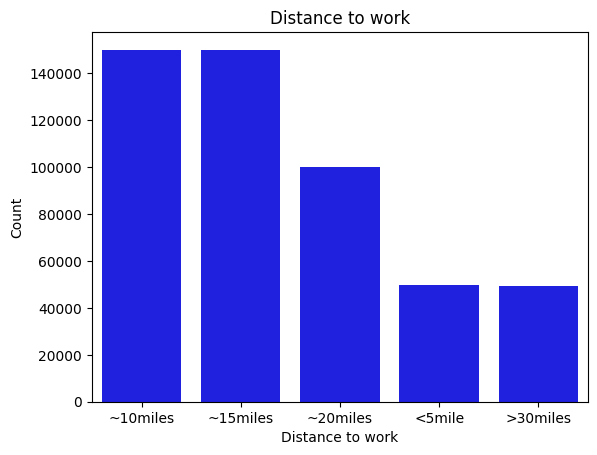

In [13]:
sns.barplot(df["Distance"].value_counts(), color="blue", alpha=1)
plt.title("Distance to work")
plt.xlabel("Distance to work")
plt.ylabel("Count")

Majority of employees live within 25 miles of the office. This is an interesting paramter as you would expect people to look for new jobs if they have to travel longer distances daily.

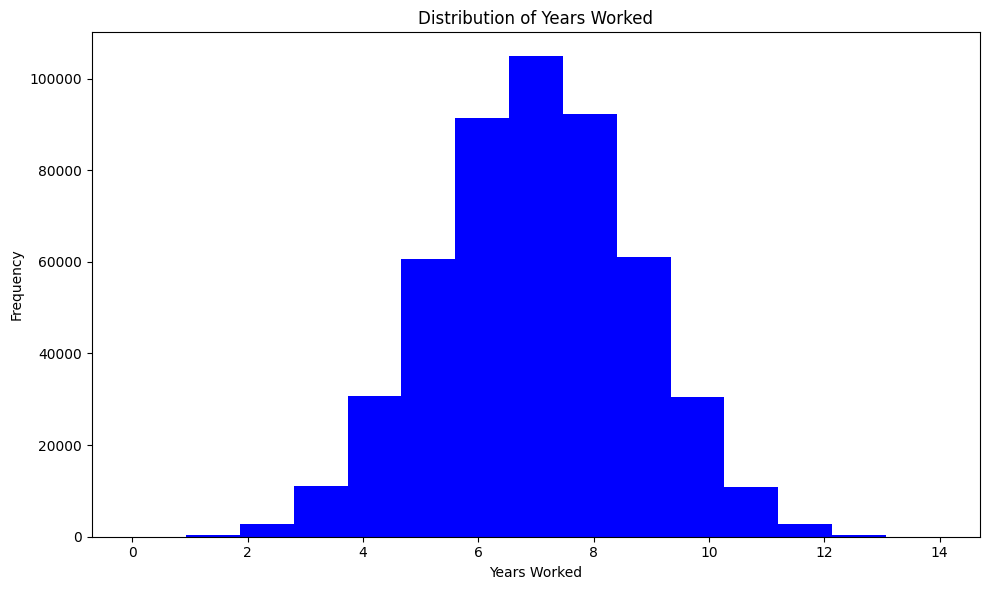

In [15]:
plt.figure(figsize=(10, 6))  
plt.hist(df["YearsWorked"], bins=15, color="blue", alpha=1)
plt.title("Distribution of Years Worked")
plt.xlabel("Years Worked")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

You would expect an employee who worked at the company for a longer amount of time to be loyal to the company and therefore less likely to leave. Futher, younger, ambitious employees could be more prone to job hopping as they are likely to work for anyone who pays them more. 

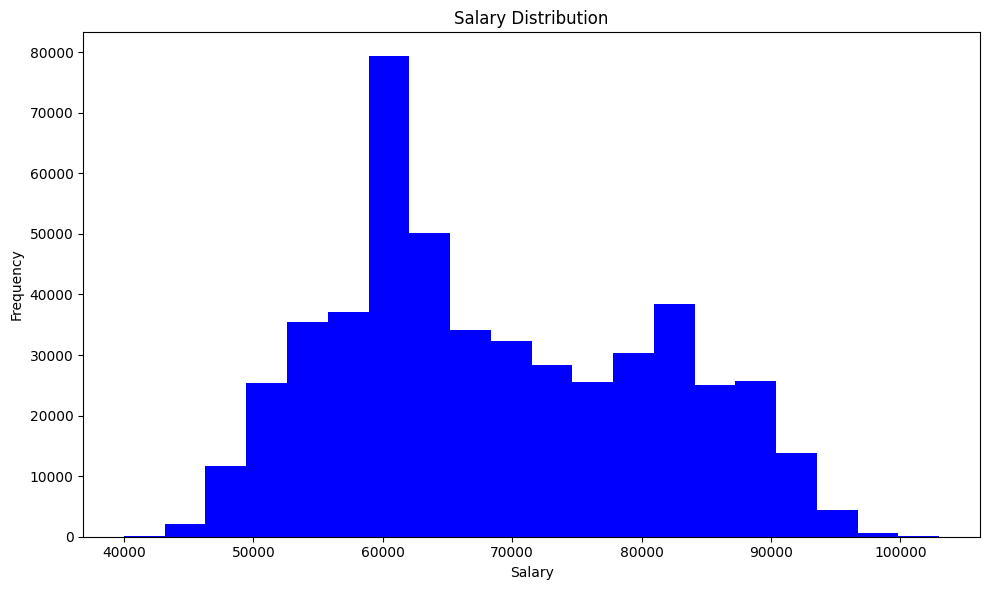

In [17]:
plt.figure(figsize=(10, 6))  
plt.hist(df["Salary"], bins=20, color="blue", alpha=1)
plt.title("Salary Distribution")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

This is also similar to previous distribution. People who are paid well will likely stay whereas, those underpaid, will likely be unsatisfied with the company and could leave if they get a better pay elsewhere.

# 3. Feature Engineering

## 3.1 Feature Extraction

### 3.1.1 Rating Difference
Difference in rating between self and supervisor can be a strong indicator of workplace dissatisfaction.

In [22]:
df['rating_diff'] = df['SelfReview']-df['SupervisorReview']

### 3.1.2 Salary Increase

Converting salary variable into numeric and taking percentage increase in salary. Smaller increases or decreases in salary may indicate whether an employee will leave.

In [24]:
df['salary_increase'] = df['Salary']/df['PreviousSalary']

### 3.1.3 Salary per Year Experience
If an employee has many years experience and a lower-than-average salary, they may be unhappy with their pay and more likely to leave.

In [26]:
df['YearsWorkedAdj'] = np.where(df['YearsWorked']==0,1, df['YearsWorked'])
df['salary_per_year'] = df['Salary'] / df['YearsWorkedAdj']

### 3.1.4 Projects per Year Experience
Similarly, employees may feel undervalued if they are not part of many projects when they have many years of experience. We can represent this as number of projects per years worked.

In [28]:
df['proj_per_year'] = df['NumOfProjects'] / df['YearsWorkedAdj']

## 3.2 Feature Selection

Not all variables/features from the dataset will be utilized. This is because, within context, these features may not have a large impact on whether someone leaves their job (e.g. TeamSize) or there is redundancy with other variables (e.g. AnnualLeaveDays is closely tied with WorkLifeBalance). In addition to the engineered features, the features that will be used are:
- Gender: Studies have shown that women are more likely to leave a job than men.
- Distance: Longer commutes can lead to frustration and make people want to look for closer jobs.
- WorkLifeBalance: People with a better work life balance may be hesitant to risk that by leaving a job.
- AttenanceRate: People who attend more meetings are likely more engaged with their job than those that don't.
- StressLevel: This can work both ways. People who are financially stressed may be less likely to leave a job because they would put themselves at financial risk. On the other hand, the job may be the source of stress.
- PeerFeedbackScore: Being surrounded by people who enjoy working with you would lead to a higher likelihood of remaining.
- ProjectComplexity: Similarly, this can go both ways. Complex projects can be more engaging but also more stressful.
- WorkSatisfactionScore: More satisfied -> less likely to leave.
- MentalWellbeingScore: Employees who are not feeling mentally well may be looking for a change of pace.
- Salary: This is one of the leading reasons people move jobs - they are looking for a higher salary. While straight salary may not be the biggest representation, pairing with salary_increase and salary_per_year can lead to useful variable interaction.

In [30]:
num_vars = ['Gender','WorkLifeBalance','AttendanceRate','StressLevel','PeerFeedbackScore','ProjectComplexity', \
            'WorkSatisfactionScore','MentalWellbeingScore','Salary','rating_diff','salary_increase','salary_per_year','proj_per_year']

cat_vars = ['Distance']
all_vars = num_vars + cat_vars

In [31]:
df[all_vars].head()

,Gender,WorkLifeBalance,AttendanceRate,StressLevel,PeerFeedbackScore,ProjectComplexity,WorkSatisfactionScore,MentalWellbeingScore,Salary,rating_diff,salary_increase,salary_per_year,proj_per_year,Distance
0,1,4,94.824165,3,2,2,3,5,73000.0,0.0,1.013889,10428.571429,2.0,>30miles
1,0,5,95.117958,4,5,1,3,1,64000.0,0.0,1.032258,6400.000000,0.9,~10miles
2,0,3,80.556122,1,1,3,7,8,74000.0,2.0,1.013699,7400.000000,1.3,~10miles
3,0,3,90.532288,1,1,4,6,5,64000.0,0.0,1.015873,12800.000000,3.0,~15miles
4,1,2,83.009193,3,3,3,3,4,64000.0,0.0,1.066667,6400.000000,1.3,~10miles


In [32]:
df[all_vars].describe()

,Gender,WorkLifeBalance,AttendanceRate,StressLevel,PeerFeedbackScore,ProjectComplexity,WorkSatisfactionScore,MentalWellbeingScore,Salary,rating_diff,salary_increase,salary_per_year,proj_per_year
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,497966.000000,500000.000000,500000.000000,500000.000000
mean,0.401232,3.002836,89.995094,3.002938,3.001480,3.001772,4.997358,5.003052,68615.506000,0.302916,1.030323,10728.028731,1.564552
std,0.490148,1.413991,5.777294,1.414613,1.413698,1.413426,2.583222,2.580972,12240.747609,1.153701,0.014621,4590.562116,1.098087
min,0.000000,1.000000,80.000031,1.000000,1.000000,1.000000,1.000000,1.000000,40000.000000,-2.000000,1.000000,3428.571429,0.071429
25%,0.000000,2.000000,84.987993,2.000000,2.000000,2.000000,3.000000,3.000000,59000.000000,0.000000,1.017544,7875.000000,0.750000
50%,0.000000,3.000000,89.988884,3.000000,3.000000,3.000000,5.000000,5.000000,66000.000000,0.000000,1.031250,9800.000000,1.428571
75%,1.000000,4.000000,94.998260,4.000000,4.000000,4.000000,7.000000,7.000000,79000.000000,1.000000,1.038961,12400.000000,2.142857
max,1.000000,5.000000,99.999969,5.000000,5.000000,5.000000,9.000000,9.000000,103000.000000,3.000000,1.105263,100000.000000,19.000000


In [33]:
# only select numeric variables
numeric_df = df[all_vars].select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

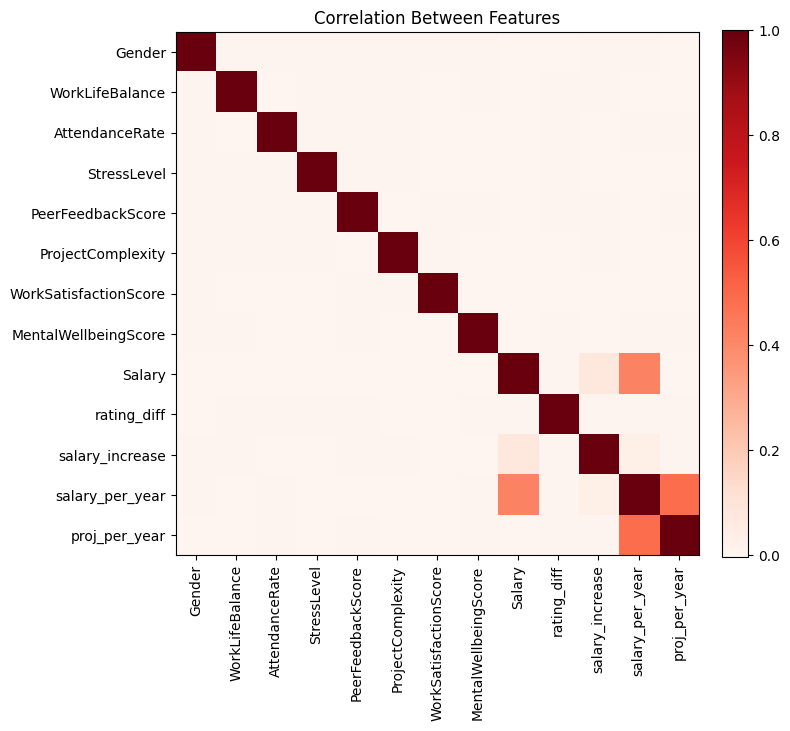

In [34]:
# plotting correlation matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(corr_matrix, cmap="Reds")
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_yticklabels(corr_matrix.columns)
ax.set_title("Correlation Between Features")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

The features look independent besides some. We extracted some new features based on salary. That's why salary related features are strongly related to each other. Multicollinearity does not really seem to be the issue for us, which is good.

# 4. Model Development
Step-by-step Plan:
1. Scale the numeric variables and encode the categorical
2. Use PCA to reduce noise in the dataset
3. Perform k-Means clustering to group employees with similar features
4. Combine into pipeline
5. Find centers of clusters
6. Use SME to determine label for cluster centers
7. Apply label to remainder of employees in cluster
8. Create Logistic Regression model and Random Forest model using the generated labels

In [37]:
# pipeline with imptuting numerical variables with median and standardizing them
num_pipe = Pipeline([('impute_missing', SimpleImputer(strategy='median', add_indicator = True)),
                           ('standardize_num', StandardScaler())
                        ])

# pipeline with imptuting categorical variables with most frequent and creating dummies
cat_pipe = Pipeline([('impute_missing_cats', SimpleImputer(strategy = 'most_frequent', add_indicator = True)),
                          ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# combining the two pipelines into a single processing pipeline
processing_pipe = ColumnTransformer(transformers=[('proc_numeric', num_pipe, num_vars),
                                                      ('proc_categorical', cat_pipe, cat_vars)])

Given that we have so many features, and some could just be noise and doing KMeans on it will take time. So, we decided to use PCA to select top-k principal components to reduce the dimension of our data.

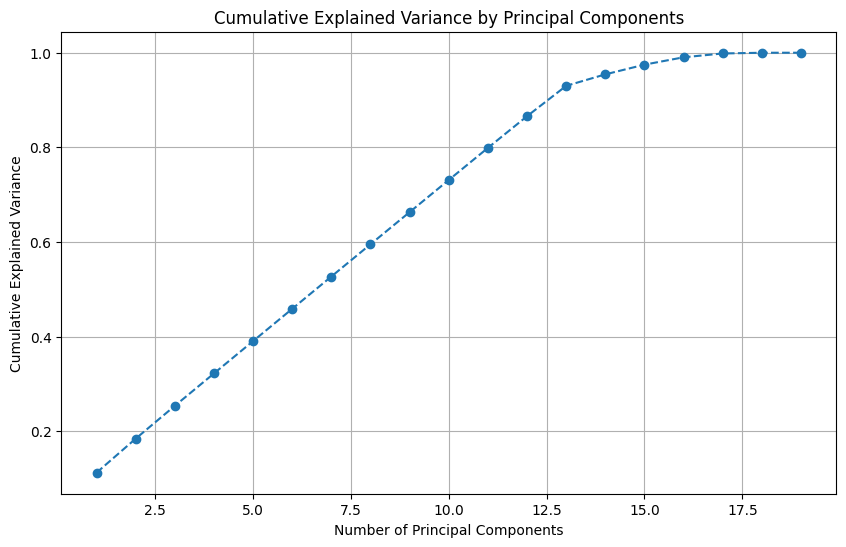

In [39]:
pca = PCA()
df_transformed_pre = processing_pipe.fit_transform(df)
pca.fit_transform(df_transformed_pre)
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

Based on the PCA explained variance chart, a good number of principal components to use will be 15. This is because it is close to 100% explained variance but does not meet 100% meaning it would be effective in reducing noise in the data.

In [41]:
df.shape

(500000, 32)

In [42]:
kmeans_pipe = Pipeline([('proc', processing_pipe),
                        ('pca', PCA(n_components = 15)),
                        ('kmeans', KMeans(n_clusters=500, n_init='auto'))
                  ])

df_transformed = kmeans_pipe.fit_transform(df)
df_transformed

array([[3.16676991, 4.57752725, 3.91072212, ..., 3.96227527, 4.14338012,
        4.23198456],
       [4.00455464, 5.42469415, 4.82751501, ..., 4.58462929, 5.12214165,
        3.10965212],
       [4.16824374, 5.49055633, 5.61306017, ..., 4.21218372, 3.96005429,
        5.54463638],
       ...,
       [3.9009263 , 5.2176154 , 4.96640387, ..., 2.24605533, 4.06661747,
        4.22558472],
       [2.69305366, 5.20412448, 4.70397864, ..., 3.95357442, 3.84371024,
        3.15126672],
       [4.22091008, 4.33548864, 3.1205556 , ..., 4.3782044 , 4.49725547,
        3.95591043]])

In [43]:
kmeans_pipe['kmeans'].cluster_centers_

array([[-0.87495031, -0.63124045,  0.18441288, ..., -0.38645938,
         0.14261595, -0.00657776],
       [ 2.58166301,  0.45469195,  0.70427754, ..., -0.96241809,
         1.66894476, -0.05972728],
       [ 0.58597603,  1.2575513 , -0.70952668, ..., -0.1817621 ,
        -0.21096843,  0.00528983],
       ...,
       [-0.57907944, -0.01865218,  1.09876784, ...,  0.29960442,
         0.02471731,  0.03409772],
       [-0.69614096,  0.30616385,  0.73284767, ...,  0.52962274,
         0.11079085,  0.04194198],
       [-0.77944432,  0.34448211, -0.39138902, ...,  0.75297952,
         0.14057758,  0.06271291]])

In [44]:
X_dist = kmeans_pipe.transform(df)
X_dist

array([[3.16676991, 4.57752725, 3.91072212, ..., 3.96227527, 4.14338012,
        4.23198456],
       [4.00455464, 5.42469415, 4.82751501, ..., 4.58462929, 5.12214165,
        3.10965212],
       [4.16824374, 5.49055633, 5.61306017, ..., 4.21218372, 3.96005429,
        5.54463638],
       ...,
       [3.9009263 , 5.2176154 , 4.96640387, ..., 2.24605533, 4.06661747,
        4.22558472],
       [2.69305366, 5.20412448, 4.70397864, ..., 3.95357442, 3.84371024,
        3.15126672],
       [4.22091008, 4.33548864, 3.1205556 , ..., 4.3782044 , 4.49725547,
        3.95591043]])

In [45]:
# Find the index of the closest cluster center for each sample
representative_idx = np.argmin(X_dist, axis=0)
print(representative_idx.shape)
representative_idx

(500,)


array([ 97023, 145059, 455153,   2176, 433249, 246642, 138159, 122955,
       393677, 456336, 394930, 370023, 383818, 452537, 347661, 198325,
       495698, 391110, 388812, 107013, 118040, 159756, 287859, 397186,
         8591, 115688, 135060, 456295, 399704, 348275, 273786, 395412,
       218013,  31391, 163395,  19084, 307878, 361341, 428661, 282556,
       218729, 275905, 492780, 323346, 147898,  28795,  53615, 237392,
       492162, 237661, 287333, 266863, 198955, 365293,  88953, 402310,
       403835,  25335, 462228,  23090, 499566, 361109, 293245, 386978,
        89913, 373241, 490526, 102300, 466814, 222200, 410066, 319721,
        33198, 155284, 374779, 166274, 472328,  94828, 282703, 215454,
       452320, 187941,  63157, 395910,  10293, 183667,   8973, 411094,
       416478, 315624,  16363, 241486, 166258, 240850, 245549, 158810,
       298014, 311765, 224514, 494116, 354329, 371635, 427059, 478811,
       195592,  11454, 384504, 117518, 412640, 320550, 459623, 199570,
      

In [46]:
df['cluster'] = kmeans_pipe.predict(df)
df['cluster']

0         388
1           7
2         418
3         163
4         230
         ... 
499995     74
499996    191
499997    497
499998    119
499999    210
Name: cluster, Length: 500000, dtype: int32

In [47]:
'''
The original class
'''
class SME():
    
    def __init__(self):
        self.asked = 0
        self.df = self.get()
        
    def get(self):
        X_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_X.csv')
        y_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_y.csv')

        X_train['Left'] = y_train
        return X_train
    
    def ask(self, valuedict):
        self.asked += 1
        #  print(self.asked)
        
        if self.asked > 500:
            raise Exception("Sorry, you have asked enough")

        arr = []
        for prop in valuedict:
            val = valuedict[prop]

            if val is None: 
                continue

            val = f"'{val}'" if isinstance(val,str) else val
            # print(prop, val)
            arr.append(f'{prop} == {val}')

            query = ' and '.join(arr)
        result = self.df.query(query)

        if len(result) == 0:
            raise Exception("I don't know")
        
        return (int)(result['Left'].mean())

In [48]:
from tqdm import tqdm

In [49]:
df['Pred'] = None

sme = SME()

cluster=0
for idx in tqdm(representative_idx):
    '''
    Here, for each cluster cn, we ask the SME for the prediction of the representative sample. This way, we can get the prediction for all the samples -
    - belonging to the corresponding cluster.
    '''
    rec_id = df['RecordId'][idx]
    pred = sme.ask({
    'RecordId': rec_id,   
})
    df['Pred'] = [ pred if c == cluster else g  for c, g in zip(df['cluster'], df['Pred'])]
    cluster+=1
    
df['Pred']

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:24<00:00,  2.44it/s]


0         0.0
1         0.0
2         0.0
3         0.0
4         1.0
         ... 
499995    0.0
499996    0.0
499997    1.0
499998    1.0
499999    0.0
Name: Pred, Length: 500000, dtype: float64

In [50]:
df.head()

,RecordId,Gender,Distance,YearsWorked,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,...,Salary,SelfReview,SupervisorReview,rating_diff,salary_increase,YearsWorkedAdj,salary_per_year,proj_per_year,cluster,Pred
0,100,1,>30miles,7,91,4,14,3,8,1,...,73000.0,4.0,4.0,0.0,1.013889,7,10428.571429,2.0,388,0.0
1,101,0,~10miles,10,52,5,9,2,10,0,...,64000.0,4.0,4.0,0.0,1.032258,10,6400.000000,0.9,7,0.0
2,102,0,~10miles,10,80,3,13,3,16,0,...,74000.0,4.0,2.0,2.0,1.013699,10,7400.000000,1.3,418,0.0
3,103,0,~15miles,5,6,3,15,5,16,0,...,64000.0,5.0,5.0,0.0,1.015873,5,12800.000000,3.0,163,0.0
4,104,1,~10miles,10,3,2,13,3,18,0,...,64000.0,4.0,4.0,0.0,1.066667,10,6400.000000,1.3,230,1.0


Now that we have the labels (Pred), we can train different models to do experiments.

In [52]:
# reducing the precision for saving memory.
df = df.astype({col: 'int32' for col in df.select_dtypes('int64').columns})
df = df.astype({col: 'float32' for col in df.select_dtypes('float64').columns})

In [53]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [54]:
train.to_parquet('train.parquet')
test.to_parquet('test.parquet')

## Converting to parquet format to reduce computational load
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [55]:
# creating training and test sets
X_train = train[all_vars]
y_train = train['Pred']

X_test = test[all_vars]
y_test = test['Pred']

In [56]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400000, 14), (400000,), (100000, 14), (100000,))

In [57]:
y_train.value_counts() / len(y_train) * 100

Pred
0.0    58.65175
1.0    41.34825
Name: count, dtype: float64

There is not much class imbalance. 55% of samples are 0 and 45% are 1. Accuracy as a metric is okay as long as a data is balanced and it will lead to incorrect analysis if there is extreme class imbalance. Just to be on safe side, we decided to go with a balanced appraoch, F1 score as our metric.

In [59]:
# extracting the features from the training set
features_in = processing_pipe.fit_transform(X_train)
features_in = processing_pipe.get_feature_names_out()
len(features_in)

19

## 4.1 Logistic Regression

In [61]:
processing_pipe

ColumnTransformer(transformers=[('proc_numeric',
                                 Pipeline(steps=[('impute_missing',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('standardize_num',
                                                  StandardScaler())]),
                                 ['Gender', 'WorkLifeBalance', 'AttendanceRate',
                                  'StressLevel', 'PeerFeedbackScore',
                                  'ProjectComplexity', 'WorkSatisfactionScore',
                                  'MentalWellbeingScore', 'Salary',
                                  'rating_diff', 'salary_increase',
                                  'salary_per_year', 'proj_per_year']),
                                ('proc_categorical',
                                 Pipeline(steps=[('impute_missing_cats',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent')),
                                                 ('create_dummies_cats',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Distance'])])

In [62]:
log_reg_pipeline = Pipeline([('proc', processing_pipe),
                             ('logreg', LogisticRegression(solver='liblinear'))
])

log_reg_param_grid = [
  {'logreg__class_weight': [None, 'balanced'], 
   'logreg__C':[0.1, 1, 10]}
 ]

# we decided to use RandomizedSearchCV instead of GridSearchCV to speed up the process
# instead of testing all combinations of parameters, RandomizedSearchCV will randomly sample a few combinations for n number of iterations
random_search = RandomizedSearchCV(
    estimator=log_reg_pipeline,
    param_distributions=log_reg_param_grid,
    n_iter=5,  
    scoring='f1', # this is our metric for optimization
    refit=True,
    cv=4,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1,  # this will use all available cores
)

random_search.fit(X_train, y_train)

random_search.best_estimator_

Pipeline(steps=[('proc',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['Gender', 'WorkLifeBalance',
                                                   'AttendanceRate',
                                                   'StressLevel',
                                                   'PeerFeedbackScore',
                                                   'ProjectComplexity',
                                                   'WorkSatisfactionScore',
                                                   'MentalWellbeingScore',
                                                   'Salar...,
                                                   'salary_increase',
                                                   'salary_per_year',
                                                   'proj_per_year']),
                                                 ('proc_categorical',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Distance'])])),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    solver='liblinear'))])

In [63]:
random_search.best_estimator_

Pipeline(steps=[('proc',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['Gender', 'WorkLifeBalance',
                                                   'AttendanceRate',
                                                   'StressLevel',
                                                   'PeerFeedbackScore',
                                                   'ProjectComplexity',
                                                   'WorkSatisfactionScore',
                                                   'MentalWellbeingScore',
                                                   'Salar...,
                                                   'salary_increase',
                                                   'salary_per_year',
                                                   'proj_per_year']),
                                                 ('proc_categorical',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Distance'])])),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    solver='liblinear'))])

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, roc_auc_score

In [65]:
def perform_deep_test_analysis(model_object: Pipeline, model_name: str) -> None:
    """"
    This function takes in a model object and model name, and performs a deep analysis on the model's performance on the test set.
    It prints classification report, confusion matrix, ROC AUC score and plots the ROC curve.
    """
    train_preds = model_object.predict(X_train)
    train_preds_proba = model_object.predict_proba(X_train)[:, 1]

    test_preds = model_object.predict(X_test)
    test_preds_proba = model_object.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, test_preds)
    
    print("\n")
    print("FOR TRAINING SET: ")
    print(classification_report(y_train, train_preds))
    print("\n")

    print("\n")
    print("FOR TESTING SET: ")
    print(classification_report(y_test, test_preds))
    print("\n")

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"ROC AUC Score: {roc_auc_score(y_test, test_preds_proba):.2%}")
    print("\n")

    fpr, tpr, _ = roc_curve(y_test, test_preds_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()



FOR TRAINING SET: 
              precision    recall  f1-score   support

         0.0       0.76      0.68      0.72    234607
         1.0       0.60      0.70      0.65    165393

    accuracy                           0.69    400000
   macro avg       0.68      0.69      0.68    400000
weighted avg       0.70      0.69      0.69    400000





FOR TESTING SET: 
              precision    recall  f1-score   support

         0.0       0.76      0.68      0.71     58619
         1.0       0.60      0.70      0.65     41381

    accuracy                           0.68    100000
   macro avg       0.68      0.69      0.68    100000
weighted avg       0.69      0.68      0.69    100000





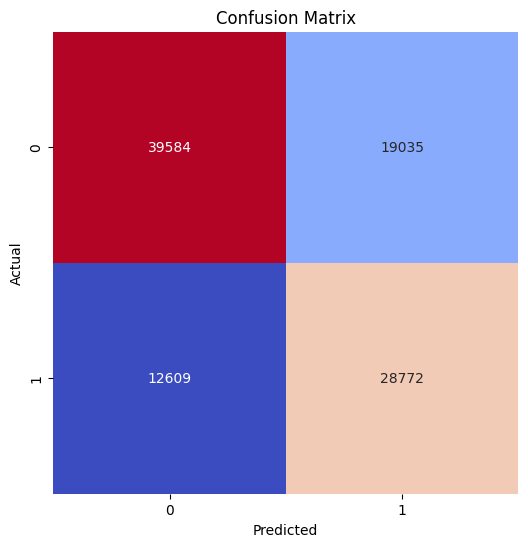

ROC AUC Score: 74.52%




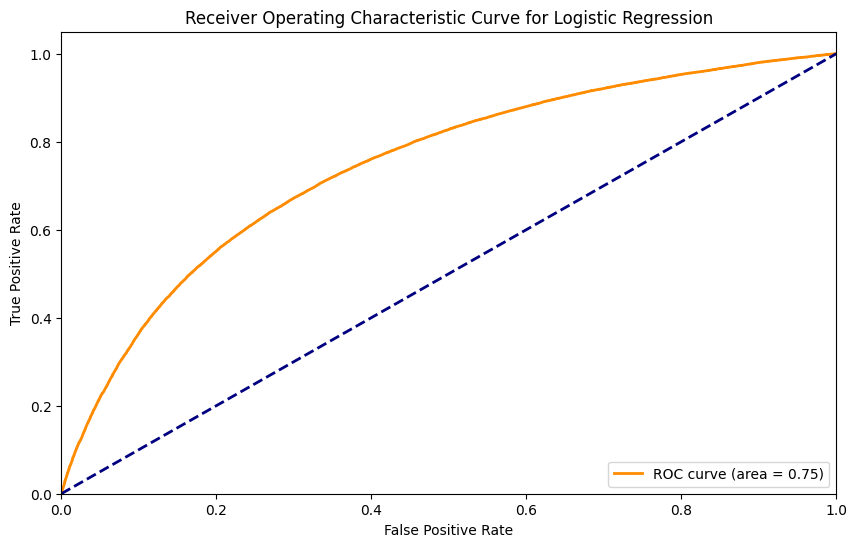

In [66]:
perform_deep_test_analysis(random_search, "Logistic Regression")

In [67]:
lr_model = random_search.best_estimator_["logreg"]
lr_model

LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear')

In [68]:
lr_model.intercept_

array([-0.08418381])

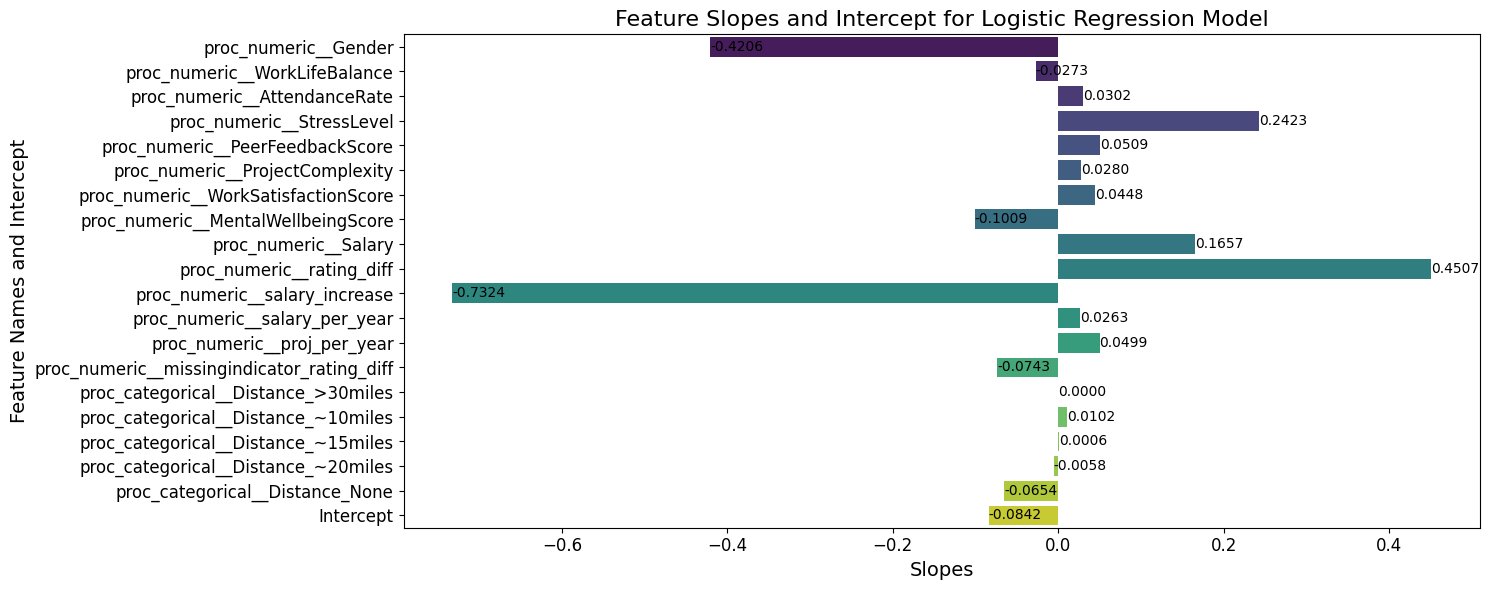

In [69]:
feature_importances = pd.DataFrame({'feature': features_in, 'slope':  lr_model.coef_[0]})
feature_importances = pd.concat([feature_importances, pd.DataFrame({'feature': ['Intercept'], 'slope': lr_model.intercept_})], ignore_index=True)

plt.figure(figsize=(15, 6))
sns.barplot(data=feature_importances, x='slope', y='feature', palette='viridis')
plt.title('Feature Slopes and Intercept for Logistic Regression Model', fontsize=16)
plt.xlabel('Slopes', fontsize=14)
plt.ylabel('Feature Names and Intercept', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for index, value in enumerate(feature_importances['slope']):
    plt.text(value, index, f'{value:.4f}', va='center', fontsize=10)
plt.tight_layout()
plt.show()


From the above confusion matrix, we can see that, model was able to correctly classify 31221 positives cases our of almost 45k positive cases, with recall being around 70%. Similarly, there are lots of false positives and false negatives. The model wrongly classified 13473 left cases as non-left. Simiarly, for 17963 non-left cases, the model predicted them as left.

Our model has precision, recall and f1 scores of 0.63, 0.7 and 0.67 respectively for class 1. It means that, out of all positive predictions made by the model, 63% of them are actually positive (True Positives), whereas 27% of them are false alarms (False Negatives). For recall, our model was able to detect 70% of all positive cases in the dataset and missed 30% of the negatives (or non-left). Finally, our F1 score is 0.69 indicating model has generally good performance on the left class. It's not perfect but there is a room for improvement.

Also, our AUC (area under the curve of ROC Curve) score is almost 75%, which indicates very good discriminative power of the model. Model is pretty good in distinguishing data from left and non-left.

What it actually means is that, if we choose a random left row and random non-left row, the chance that the model will assign higher probability to the left row is 75%. Essentially, the model is correctly ranking left rows higher than non-left rows 75% of the time.

## 4.2 Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([('proc', processing_pipe),
                        ('rf', RandomForestClassifier())
                  ])

rf_param_grid = [
    {
        'rf__n_estimators': [100, 200, 500], 
        'rf__max_depth': [5, 6, 7, 8],
        "rf__n_jobs": [-1],
    }
]

# we decided to use RandomizedSearchCV instead of GridSearchCV to speed up the process
# instead of testing all combinations of parameters, RandomizedSearchCV will randomly sample a few combinations for n number of iterations
random_search_RF = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_grid,
    n_iter=7,  
    scoring='accuracy',
    refit=True,
    cv=4,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1,  # this will use all available cores
)

rf_fit = random_search_RF.fit(X_train, y_train)
random_search_RF.best_estimator_

Pipeline(steps=[('proc',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['Gender', 'WorkLifeBalance',
                                                   'AttendanceRate',
                                                   'StressLevel',
                                                   'PeerFeedbackScore',
                                                   'ProjectComplexity',
                                                   'WorkSatisfactionScore',
                                                   'MentalWellbeingScore',
                                                   'Salary', 'rating_diff',
                                                   'salary_increase',
                                                   'salary_per_year',
                                                   'proj_per_year']),
                                                 ('proc_categorical',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Distance'])])),
                ('rf', RandomForestClassifier(max_depth=8, n_jobs=-1))])



FOR TRAINING SET: 
              precision    recall  f1-score   support

         0.0       0.74      0.86      0.80    234607
         1.0       0.74      0.57      0.65    165393

    accuracy                           0.74    400000
   macro avg       0.74      0.72      0.72    400000
weighted avg       0.74      0.74      0.73    400000





FOR TESTING SET: 
              precision    recall  f1-score   support

         0.0       0.74      0.86      0.79     58619
         1.0       0.74      0.56      0.64     41381

    accuracy                           0.74    100000
   macro avg       0.74      0.71      0.72    100000
weighted avg       0.74      0.74      0.73    100000





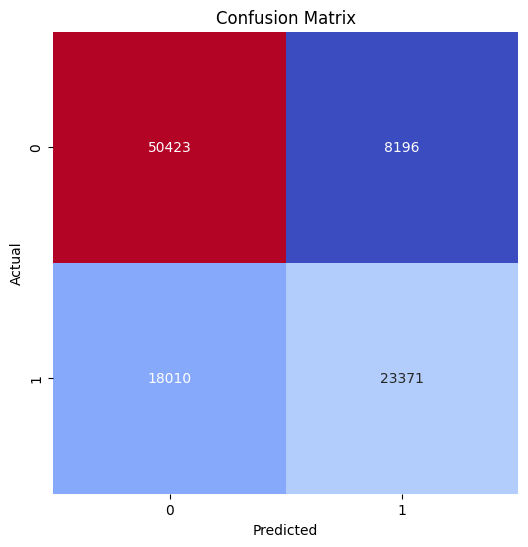

ROC AUC Score: 81.27%




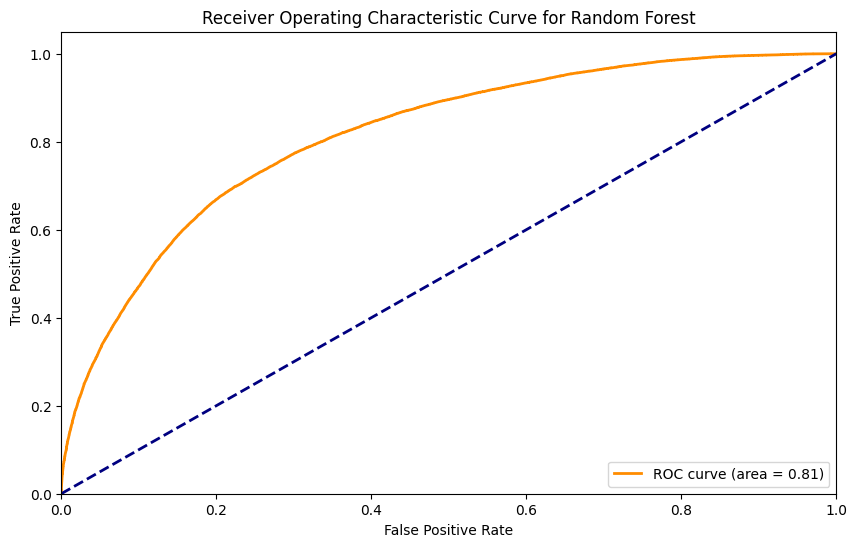

In [73]:
perform_deep_test_analysis(random_search_RF, "Random Forest")

In [74]:
rf_model = random_search_RF.best_estimator_["rf"]
rf_model

RandomForestClassifier(max_depth=8, n_jobs=-1)

In [75]:
feature_importances = pd.DataFrame({'feature': features_in, 'importance': rf_model.feature_importances_})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

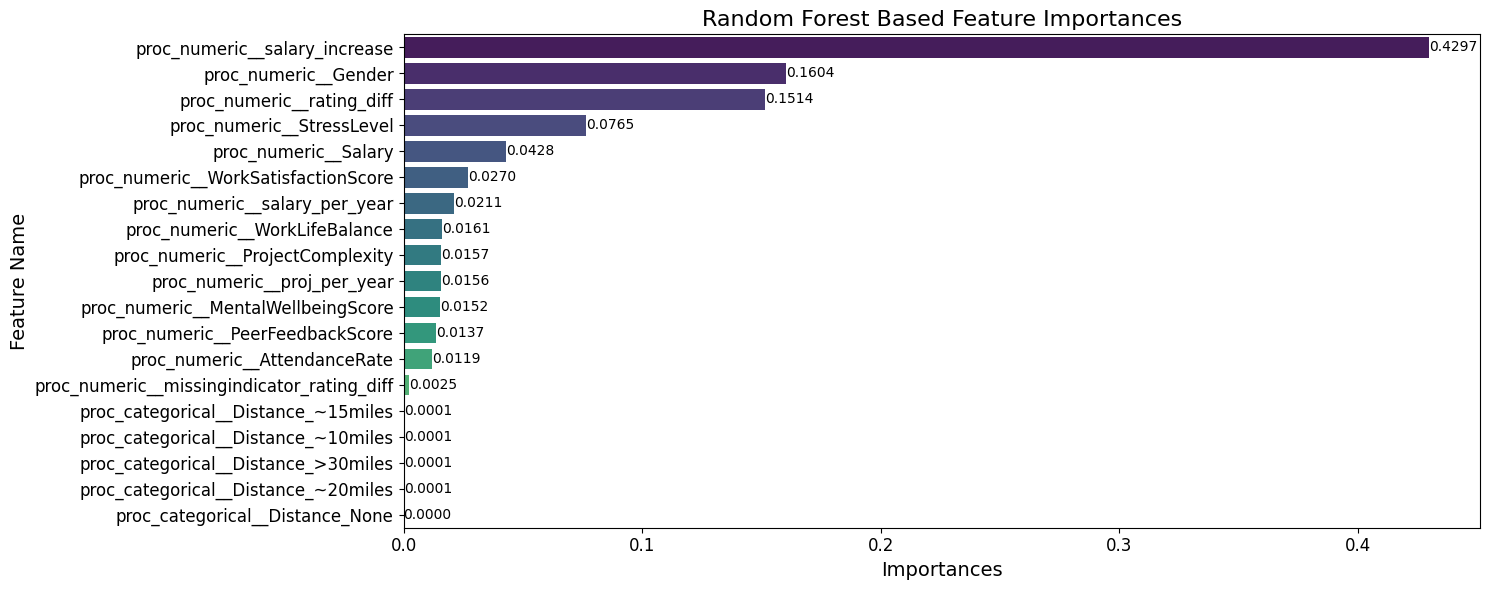

In [76]:
plt.figure(figsize=(15, 6))
sns.barplot(data=feature_importances, x='importance', y='feature', palette='viridis')
plt.title('Random Forest Based Feature Importances', fontsize=16)
plt.xlabel('Importances', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for index, value in enumerate(feature_importances['importance']):
    plt.text(value, index, f'{value:.4f}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

From the above confusion matrix, we can see that, model was able to correctly classify 28377 positives cases our of almost 45k positive cases, with recall being around 70%. Similarly, there are lots of false positives and false negatives. The model wrongly classified 16317 left cases as non-left. Simiarly, for 9761 non-left cases, the model predicted them as left. The FNR of this model is lower than that of Logistic Regression probably as its precision is higher.

Our model has precision, recall and f1 scores of 0.74, 0.63 and 0.69 respectively for class 1. It means that, out of all positive predictions made by the model, 74% of them are actually positive (True Positives), whereas 26% of them are false alarms (False Negatives). For recall, our model was able to detect 63% of all positive cases in the dataset and missed 37% of the negatives (or non-left). Finally, our F1 score is 0.69 indicating model has generally good performance on the left class. It's not perfect but there is a room for improvement.

Also, our AUC (area under the curve of ROC Curve) score is almost 81.7%, which indicates very good discriminative power of the model. Model is pretty good in distinguishing data from left and non-left.

What it actually means is that, if we choose a random left row and random non-left row, the chance that the model will assign higher probability to the left row is 81%. Essentially, the model is correctly ranking left rows higher than non-left rows 81% of the time.

# 6. Conclusion

We experimented with 2 models: Logistic Regression and Random Forest. RF model beat the LR model by a reasonable margin. But, the overall F1 score/accuracy of these models is still subpar. We believe with robust feature engineering, we can achieve higher performance. Given that we could only use up to 500 labels for labeling cluster centroids, we believe a lot of data points might have been mislabelled, leading to slightly poor generalization for our models. So, <b>robust feature engineering + tuning number of clusters </b> should be enough to squeeze more performance in the model.

# 7. Exporting Best Model

Based on our analysis, we decided to go with Random Forest model as it has the best F1 score and performance. We will export the model and load it onto the production notebook to do predictions.

In [82]:
import joblib

# Save the Random Forest model to a pickle file
joblib.dump(random_search_RF.best_estimator_, 'random_forest_model.pkl')
print("Random Forest model exported successfully!")

Random Forest model exported successfully!
